In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from IPython.display import HTML

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


set constant

In [2]:

CHENNELS = 3,
EPOCHS = 5

In [3]:
import tensorflow as tf

# Set your desired image size
IMAGE_SIZE = 256  
BATCH_SIZE = 32  
CHENNELS = 3
EPOCHS = 5

image_directory = '/kaggle/input/eye-data-set-5-class/eye_Data_set'


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_directory,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)




Found 4317 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal', 'retina_disease']

Image shape

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
(32,)
[2 3 3 1 2 0 0 0 1 3 2 1 1 2 2 0 1 0 2 0 0 3 1 1 1 2 2 3 3 3 1 0]


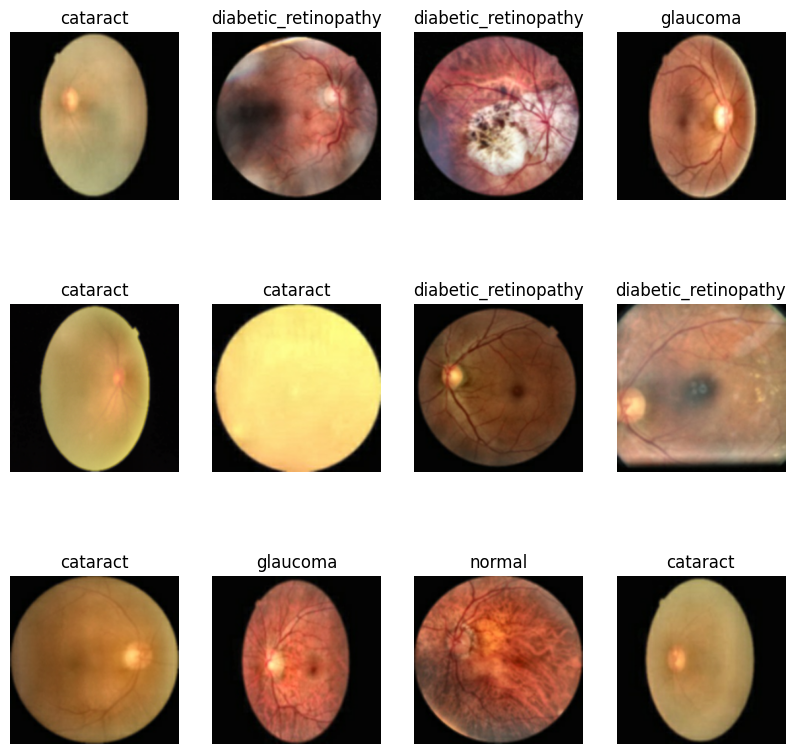

In [6]:
plt.figure(figsize=(10,10))
for image_batch , labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

Spliting datast

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

108

In [12]:
len(test_ds)

14

In [13]:
len(val_ds)

13

# Prefetch Data

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building Model

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 256)
])

Data Augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Applying data augmentation on train_ds

In [17]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Archtiecture

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHENNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='sigmoid')
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

In [20]:
model.compile(optimizer='adam',
             loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics= ['accuracy']
             
             )

In [21]:
%%time
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20
)

Epoch 1/20
108/108 [==============================] - 47s 315ms/step - loss: 1.9000 - accuracy: 0.3330 - val_loss: 1.1422 - val_accuracy: 0.4939
Epoch 2/20
108/108 [==============================] - 31s 282ms/step - loss: 1.1587 - accuracy: 0.4751 - val_loss: 0.9234 - val_accuracy: 0.5472
Epoch 3/20
108/108 [==============================] - 31s 285ms/step - loss: 0.9882 - accuracy: 0.5570 - val_loss: 0.7897 - val_accuracy: 0.6247
Epoch 4/20
108/108 [==============================] - 30s 282ms/step - loss: 0.8941 - accuracy: 0.5975 - val_loss: 0.7864 - val_accuracy: 0.6416
Epoch 5/20
108/108 [==============================] - 30s 280ms/step - loss: 0.8064 - accuracy: 0.6484 - val_loss: 0.6818 - val_accuracy: 0.6731
Epoch 6/20
108/108 [==============================] - 30s 280ms/step - loss: 0.7437 - accuracy: 0.6895 - val_loss: 0.5814 - val_accuracy: 0.7312
Epoch 7/20
108/108 [==============================] - 31s 283ms/step - loss: 0.6717 - accuracy: 0.7188 - val_loss: 0.5670 - val_ac

In [22]:
model.evaluate(test_ds)

14/14 [==============================] - 4s 27ms/step - loss: 0.4448 - accuracy: 0.8348


[0.44482094049453735, 0.8348214030265808]

In [23]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 108}

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

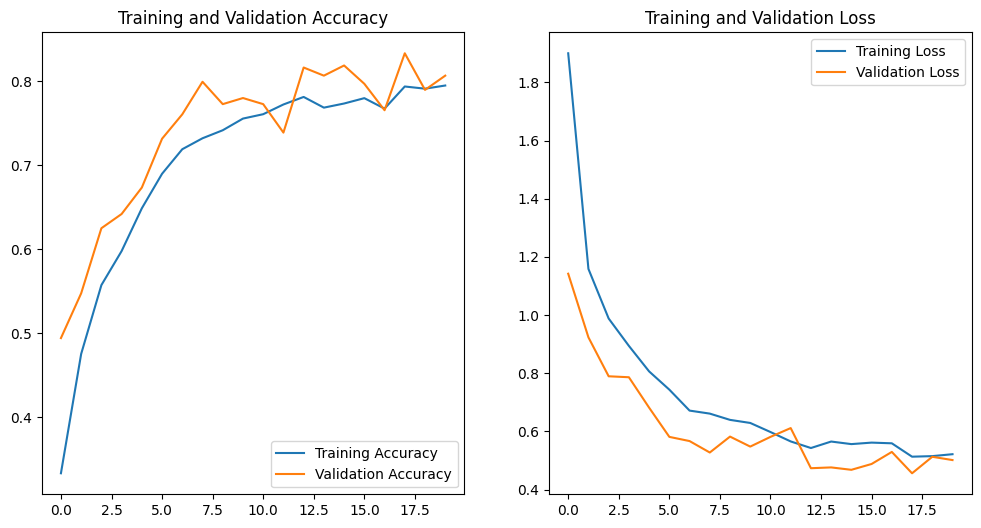

In [26]:
EPOCHS = len(acc)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Run Prediction on a sample image

first image to predict
actual lable: glaucoma
1/1 [==============================] - 0s 175ms/step
prediction label:  glaucoma


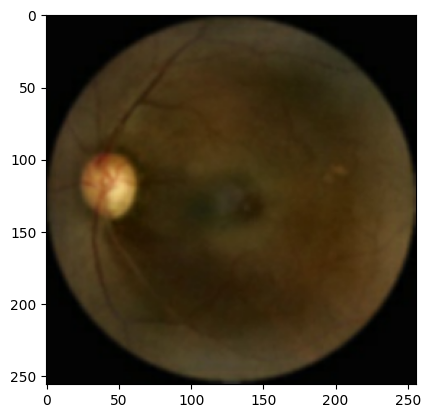

In [28]:
for image_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print('first image to predict')
    plt.imshow(first_image)
    print('actual lable:' , class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('prediction label: ', class_names[np.argmax(batch_prediction[0])])
    

make prediction interface

1/1 [==============================] - 0s 21ms/step


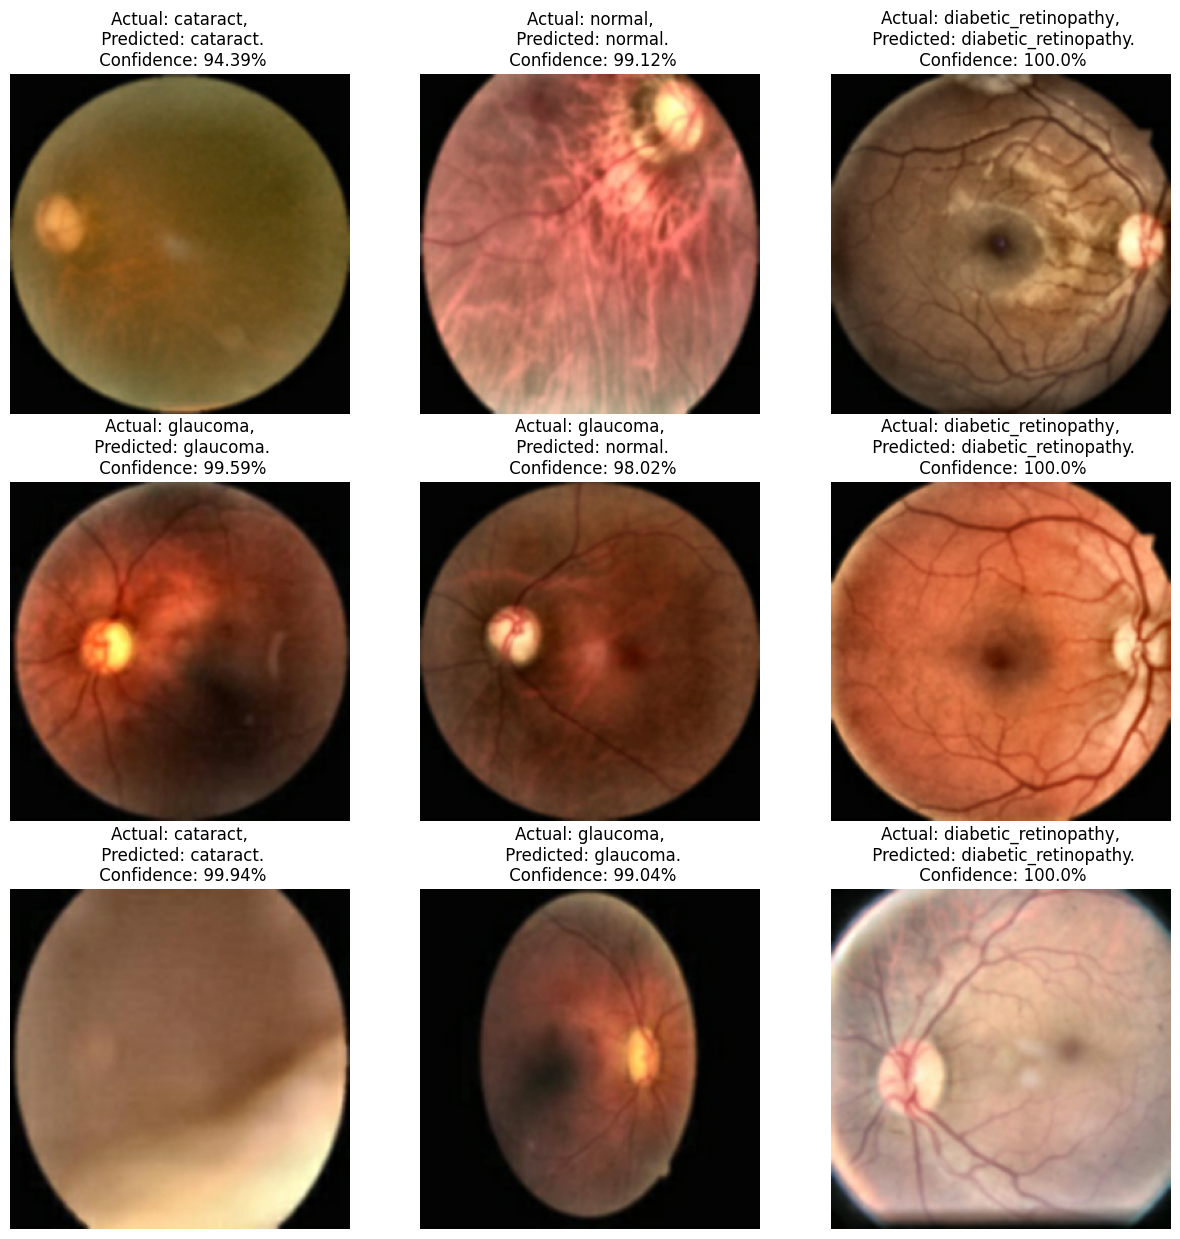

In [29]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        prediction_class, confidance = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {prediction_class}.\n Confidence: { confidance}%")
        plt.axis('off')